# Preprocessing Pipeline Testing

This notebook tests different preprocessing pipelines for movie genre classification to find the optimal feature extraction and selection strategy.

## Objectives:
1. Test current pipeline (TF-IDF → L2 Norm → chi2 Selection)
2. Test Mutual Information feature selection (replacing chi2)
3. Test TruncatedSVD dimensionality reduction
4. Test combined SVD + Mutual Information pipeline
5. Test SVD-only pipeline (no feature selection)
6. Test NMF (Non-Negative Matrix Factorization) dimensionality reduction
7. Test combined NMF + chi2 pipeline
8. Test NMF-only pipeline (no feature selection)
9. Compare all pipelines using cross-validation
10. Visualize performance comparisons


In [1]:
# Imports and Setup
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer
import time

# Project imports
from descriptions.config import INTERIM_DATA_DIR
from descriptions.dataset import load_interim
from descriptions.modeling.preprocess import _generate_targets, _preprocess_genres

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports complete")


2026-01-05 22:40:27.999 | INFO     | descriptions.config:<module>:11 - PROJ_ROOT path is: /Users/christianfullerton/Developer/Python Workspace/movie_genre_model


✓ Imports complete


## 1. Load and Prepare Data


In [2]:
# Load interim data
print("Loading data...")
data = load_interim()
print(f"✓ Loaded {len(data)} samples")

# Prepare text descriptions and labels
print("\nPreparing text descriptions...")
texts = data["description"].fillna("").astype(str)

# Prepare multi-label targets
print("Preparing multi-label targets...")
y, mlb, filtered_index = _generate_targets(data, mlb=None)
# Filter texts to match filtered data
if len(filtered_index) < len(data):
    index_map = {idx: i for i, idx in enumerate(data.index)}
    filtered_positions = [index_map[idx] for idx in filtered_index]
    texts = texts.iloc[filtered_positions].reset_index(drop=True)

print(f"✓ Texts shape: {len(texts)}")
print(f"✓ Labels shape: {y.shape}")
print(f"✓ Number of genres: {len(mlb.classes_)}")
print(f"\nGenres: {list(mlb.classes_)}")

# Split into train/test (use same random_state as training: 42)
print("\nSplitting data into train/test sets...")
texts_train, texts_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"\n✓ Data split complete:")
print(f"  - Training samples: {len(texts_train)}")
print(f"  - Test samples: {len(texts_test)}")


Loading data...
2026-01-05 22:40:29.348 | INFO     | descriptions.dataset:load_interim:99 - Loading interim data from /Users/christianfullerton/Developer/Python Workspace/movie_genre_model/data/interim/cleaned_movies.csv...
2026-01-05 22:40:29.417 | DEBUG    | descriptions.dataset:load_interim:103 - Loaded with index column
2026-01-05 22:40:29.418 | SUCCESS  | descriptions.dataset:load_interim:108 - ✓ Data loaded successfully: 9087 rows, 2 columns
✓ Loaded 9087 samples

Preparing text descriptions...
Preparing multi-label targets...
2026-01-05 22:40:29.421 | INFO     | descriptions.modeling.preprocess:_generate_targets:83 - Generating multi-label targets from 9087 samples...
2026-01-05 22:40:29.421 | INFO     | descriptions.modeling.preprocess:_preprocess_genres:45 - Starting genre preprocessing: cleaning and splitting genre strings
2026-01-05 22:40:29.421 | DEBUG    | descriptions.modeling.preprocess:_preprocess_genres:48 - Filling missing genres with empty strings
2026-01-05 22:40:29

## 2. Define Multi-Label Mutual Information Function

Since `mutual_info_classif` doesn't support multi-label data directly, we'll create a wrapper that computes MI for each label and aggregates the scores.


In [3]:
# Create a multi-label wrapper for mutual information
# mutual_info_classif only works with 1D targets, so we compute MI for each label
# and aggregate (mean) the scores
def mutual_info_multilabel(X, y):
    """
    Compute mutual information for multi-label classification.
    
    Computes MI for each label independently and returns the mean score.
    
    Args:
        X: Feature matrix (n_samples, n_features)
        y: Multi-label target matrix (n_samples, n_labels)
    
    Returns:
        Array of MI scores for each feature (n_features,)
    """
    scores_list = []
    for label_idx in range(y.shape[1]):
        y_single = y[:, label_idx]
        mi_scores = mutual_info_classif(X, y_single, random_state=42)
        scores_list.append(mi_scores)
    
    # Aggregate: mean across labels
    mi_scores_mean = np.mean(scores_list, axis=0)
    return mi_scores_mean

print("✓ Multi-label mutual information function defined")


✓ Multi-label mutual information function defined


## 3. Define Preprocessing Pipelines

We'll test 7 different preprocessing pipelines:
1. **Current**: TF-IDF → L2 Norm → chi2 Selection
2. **Mutual Info**: TF-IDF → L2 Norm → Mutual Information Selection (multi-label)
3. **SVD + Mutual Info**: TF-IDF → SVD → L2 Norm → Mutual Information Selection
4. **SVD Only**: TF-IDF → SVD → L2 Norm
5. **NMF Only**: TF-IDF → NMF → L2 Norm
6. **NMF + chi2**: TF-IDF → NMF → L2 Norm → chi2 Selection
7. **NMF + Mutual Info**: TF-IDF → NMF → L2 Norm → Mutual Information Selection


In [4]:
# Base TF-IDF parameters (current settings)
tfidf_params = {
    'max_features': 10000,
    'stop_words': 'english',
    'ngram_range': (1, 3),
    'sublinear_tf': True,
    'max_df': 0.7,
    'min_df': 3,
    'use_idf': True
}

# Define preprocessing pipelines
pipelines = {
    'Current (chi2)': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('normalize', Normalizer(norm='l2')),
        ('select', SelectKBest(score_func=chi2, k=4500))
    ]),
    
    'NMF Only': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('nmf', NMF(n_components=2000, random_state=42, max_iter=50)),
        ('normalize', Normalizer(norm='l2'))
    ]),
    
    'NMF + chi2': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('nmf', NMF(n_components=2000, random_state=42, max_iter=50)),
        ('normalize', Normalizer(norm='l2')),
        ('select', SelectKBest(score_func=chi2, k=4500))
    ]),
    
    'NMF + Mutual Info': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('nmf', NMF(n_components=2000, random_state=42, max_iter=50)),
        ('normalize', Normalizer(norm='l2')),
        ('select', SelectKBest(score_func=mutual_info_multilabel, k=4500))
    ])
}

print("✓ Preprocessing pipelines defined:")
for name in pipelines.keys():
    print(f"  - {name}")


✓ Preprocessing pipelines defined:
  - Current (chi2)
  - NMF Only
  - NMF + chi2
  - NMF + Mutual Info


## 4. Test Pipelines with Cross-Validation

We'll use LinearSVC with default parameters (same as baseline) to evaluate each preprocessing pipeline.


In [5]:
# Create base model (LinearSVC with baseline parameters)
base_svc = LinearSVC(
    C=0.1,
    penalty='l2',
    loss='squared_hinge',
    max_iter=1000,
    tol=1e-3,
    class_weight='balanced',
    dual=False,
    random_state=42
)
model = OneVsRestClassifier(base_svc)

# Use F1-micro as the scoring metric
scorer = make_scorer(f1_score, average='micro', zero_division=0)

# Store results
results = {
    'pipeline': [],
    'cv_mean': [],
    'cv_std': [],
    'fit_time': [],
    'transform_time': []
}

print("Testing preprocessing pipelines with 5-fold cross-validation...")
print("=" * 70)

for name, preprocessor in pipelines.items():
    print(f"\n{'='*70}")
    print(f"Testing: {name}")
    print(f"{'='*70}")
    
    # Time the preprocessing fitting
    start_time = time.time()
    X_train_processed = preprocessor.fit_transform(texts_train, y_train)
    fit_time = time.time() - start_time
    
    # Time the preprocessing transformation (on test data)
    start_time = time.time()
    X_test_processed = preprocessor.transform(texts_test)
    transform_time = time.time() - start_time
    
    print(f"✓ Preprocessing complete")
    print(f"  Final feature shape: {X_train_processed.shape}")
    print(f"  Fit time: {fit_time:.2f}s")
    print(f"  Transform time: {transform_time:.2f}s")
    
    # Cross-validation with the preprocessed features
    print(f"  Running 5-fold cross-validation...")
    cv_scores = cross_val_score(
        model, 
        X_train_processed, 
        y_train, 
        cv=5, 
        scoring=scorer,
        n_jobs=-1
    )
    
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    print(f"  CV F1-micro: {cv_mean:.4f} ± {cv_std:.4f}")
    
    # Store results
    results['pipeline'].append(name)
    results['cv_mean'].append(cv_mean)
    results['cv_std'].append(cv_std)
    results['fit_time'].append(fit_time)
    results['transform_time'].append(transform_time)

print(f"\n{'='*70}")
print("✓ All pipelines tested")


Testing preprocessing pipelines with 5-fold cross-validation...

Testing: Current (chi2)
✓ Preprocessing complete
  Final feature shape: (7248, 4500)
  Fit time: 1.44s
  Transform time: 0.11s
  Running 5-fold cross-validation...


/Users/christianfullerton/miniforge3/envs/movie_genre_model/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/christianfullerton/miniforge3/envs/movie_genre_model/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/christianfullerton/miniforge3/envs/movie_genre_model/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resou

  CV F1-micro: 0.6175 ± 0.0065

Testing: NMF Only
✓ Preprocessing complete
  Final feature shape: (7248, 2000)
  Fit time: 4896.67s
  Transform time: 60.13s
  Running 5-fold cross-validation...


/Users/christianfullerton/miniforge3/envs/movie_genre_model/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/christianfullerton/miniforge3/envs/movie_genre_model/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/christianfullerton/miniforge3/envs/movie_genre_model/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resou

  CV F1-micro: 0.4630 ± 0.0072

Testing: NMF + chi2
✓ Preprocessing complete
  Final feature shape: (7248, 2000)
  Fit time: 4881.08s
  Transform time: 60.02s
  Running 5-fold cross-validation...


/Users/christianfullerton/miniforge3/envs/movie_genre_model/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/christianfullerton/miniforge3/envs/movie_genre_model/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/christianfullerton/miniforge3/envs/movie_genre_model/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resou

  CV F1-micro: 0.4630 ± 0.0072

Testing: NMF + Mutual Info
✓ Preprocessing complete
  Final feature shape: (7248, 2000)
  Fit time: 207591.56s
  Transform time: 3706.18s
  Running 5-fold cross-validation...


/Users/christianfullerton/miniforge3/envs/movie_genre_model/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/christianfullerton/miniforge3/envs/movie_genre_model/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/christianfullerton/miniforge3/envs/movie_genre_model/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resou

  CV F1-micro: 0.4630 ± 0.0072

✓ All pipelines tested


## 4. Results Summary and Comparison


In [6]:
# Create results DataFrame
results_df = pd.DataFrame(results)
baseline_score = results_df.loc[results_df['pipeline'] == 'Current (chi2)', 'cv_mean'].values[0]
results_df['improvement'] = results_df['cv_mean'] - baseline_score
results_df = results_df.sort_values('cv_mean', ascending=False)

print("\n📊 PREPROCESSING PIPELINE COMPARISON")
print("=" * 70)
print(results_df.to_string(index=False))
print("=" * 70)

# Find best pipeline
best_pipeline_name = results_df.iloc[0]['pipeline']
best_score = results_df.iloc[0]['cv_mean']
print(f"\n🏆 Best Pipeline: {best_pipeline_name}")
print(f"   CV F1-micro Score: {best_score:.4f} ± {results_df.iloc[0]['cv_std']:.4f}")



📊 PREPROCESSING PIPELINE COMPARISON
         pipeline  cv_mean   cv_std      fit_time  transform_time  improvement
   Current (chi2) 0.617482 0.006456      1.443908        0.109543     0.000000
         NMF Only 0.462979 0.007245   4896.670166       60.134955    -0.154502
       NMF + chi2 0.462979 0.007245   4881.083272       60.018034    -0.154502
NMF + Mutual Info 0.462979 0.007245 207591.555125     3706.177811    -0.154502

🏆 Best Pipeline: Current (chi2)
   CV F1-micro Score: 0.6175 ± 0.0065


## 5. Visualizations


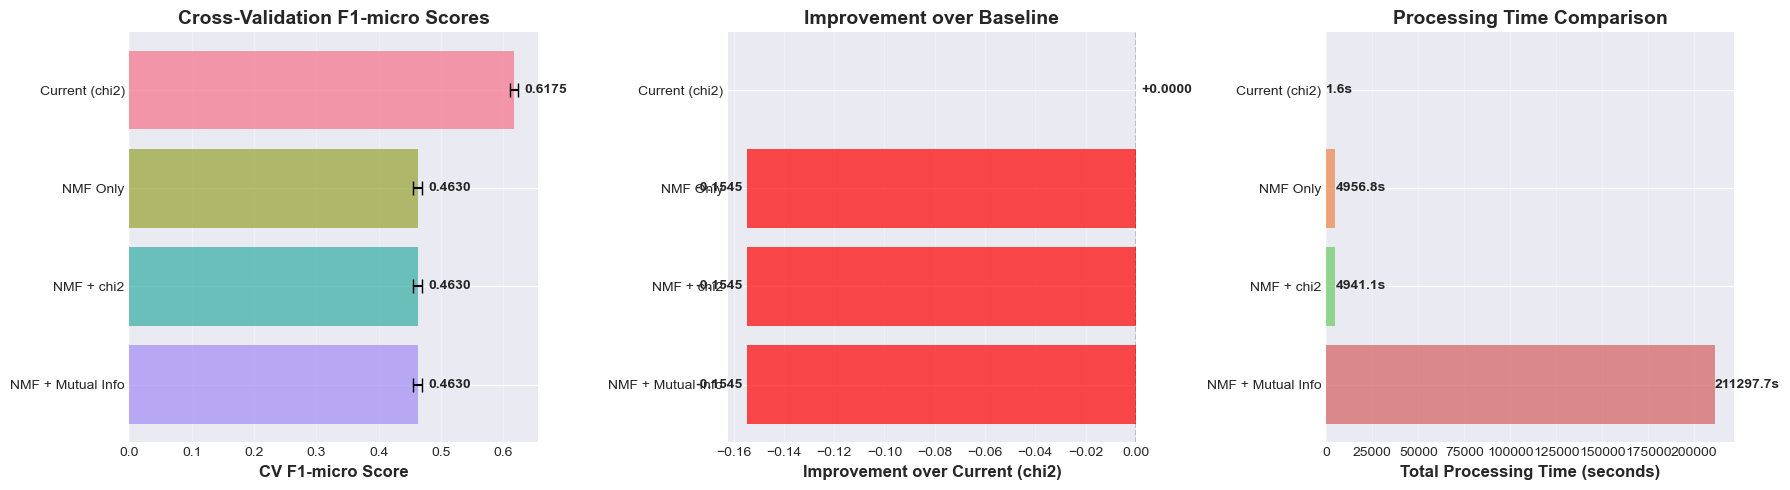


✓ Visualizations complete


In [7]:
# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. CV Scores Comparison
ax1 = axes[0]
x_pos = np.arange(len(results_df))
bars = ax1.barh(x_pos, results_df['cv_mean'], xerr=results_df['cv_std'], 
                capsize=5, alpha=0.7, color=sns.color_palette("husl", len(results_df)))
ax1.set_yticks(x_pos)
ax1.set_yticklabels(results_df['pipeline'])
ax1.set_xlabel('CV F1-micro Score', fontsize=12, fontweight='bold')
ax1.set_title('Cross-Validation F1-micro Scores', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()  # Top pipeline at top

# Add value labels
for i, (mean, std) in enumerate(zip(results_df['cv_mean'], results_df['cv_std'])):
    ax1.text(mean + std + 0.01, i, f'{mean:.4f}', 
            va='center', fontweight='bold')

# 2. Improvement over baseline
ax2 = axes[1]
colors = ['green' if x >= 0 else 'red' for x in results_df['improvement']]
bars = ax2.barh(x_pos, results_df['improvement'], alpha=0.7, color=colors)
ax2.set_yticks(x_pos)
ax2.set_yticklabels(results_df['pipeline'])
ax2.set_xlabel('Improvement over Current (chi2)', fontsize=12, fontweight='bold')
ax2.set_title('Improvement over Baseline', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

# Add value labels
for i, improvement in enumerate(results_df['improvement']):
    label = f'+{improvement:.4f}' if improvement >= 0 else f'{improvement:.4f}'
    ax2.text(improvement + (0.002 if improvement >= 0 else -0.002), i, label,
            va='center', ha='right' if improvement < 0 else 'left', fontweight='bold')

# 3. Processing Time Comparison
ax3 = axes[2]
total_time = results_df['fit_time'] + results_df['transform_time']
bars = ax3.barh(x_pos, total_time, alpha=0.7, color=sns.color_palette("muted", len(results_df)))
ax3.set_yticks(x_pos)
ax3.set_yticklabels(results_df['pipeline'])
ax3.set_xlabel('Total Processing Time (seconds)', fontsize=12, fontweight='bold')
ax3.set_title('Processing Time Comparison', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
ax3.invert_yaxis()

# Add value labels
for i, time_val in enumerate(total_time):
    ax3.text(time_val + 0.5, i, f'{time_val:.1f}s', 
            va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Visualizations complete")


## 6. Test Best Pipeline on Test Set

Train the best preprocessing pipeline on the full training set and evaluate on test set.


In [8]:
# Get the best pipeline
best_preprocessor = pipelines[best_pipeline_name]

print(f"Training best pipeline ({best_pipeline_name}) on full training set...")
print("=" * 70)

# Fit on training data
X_train_final = best_preprocessor.fit_transform(texts_train, y_train)
X_test_final = best_preprocessor.transform(texts_test)

print(f"✓ Preprocessing complete")
print(f"  Training features shape: {X_train_final.shape}")
print(f"  Test features shape: {X_test_final.shape}")

# Train model
print(f"\nTraining LinearSVC model...")
start_time = time.time()
model.fit(X_train_final, y_train)
training_time = time.time() - start_time
print(f"✓ Model trained in {training_time:.2f} seconds")

# Evaluate on test set
from sklearn.metrics import precision_score, recall_score, hamming_loss, jaccard_score

y_pred = model.predict(X_test_final)

test_metrics = {
    'f1_micro': f1_score(y_test, y_pred, average='micro'),
    'f1_macro': f1_score(y_test, y_pred, average='macro'),
    'precision_micro': precision_score(y_test, y_pred, average='micro', zero_division=0),
    'recall_micro': recall_score(y_test, y_pred, average='micro', zero_division=0),
    'hamming_loss': hamming_loss(y_test, y_pred),
    'jaccard_score': jaccard_score(y_test, y_pred, average='micro', zero_division=0),
}

print(f"\n📊 TEST SET METRICS ({best_pipeline_name})")
print("=" * 70)
for metric, value in test_metrics.items():
    print(f"  {metric:20s}: {value:.4f} ({value * 100:.2f}%)")
print("=" * 70)


Training best pipeline (Current (chi2)) on full training set...
✓ Preprocessing complete
  Training features shape: (7248, 4500)
  Test features shape: (1812, 4500)

Training LinearSVC model...
✓ Model trained in 0.16 seconds

📊 TEST SET METRICS (Current (chi2))
  f1_micro            : 0.6096 (60.96%)
  f1_macro            : 0.5755 (57.55%)
  precision_micro     : 0.5459 (54.59%)
  recall_micro        : 0.6901 (69.01%)
  hamming_loss        : 0.1619 (16.19%)
  jaccard_score       : 0.4384 (43.84%)


## 7. Summary and Recommendations

Based on the results above, choose the preprocessing pipeline that:
- Maximizes cross-validation F1-micro score
- Provides acceptable processing time
- Shows consistent improvement over baseline

### Key Findings:
1. **Mutual Information** vs chi2: Tests whether mutual information improves over chi2 for feature selection
2. **TruncatedSVD**: Tests whether dimensionality reduction with SVD captures semantic relationships better
3. **SVD + Feature Selection**: Tests whether combining SVD with feature selection is beneficial
4. **SVD Only**: Tests whether SVD alone is sufficient (simpler pipeline)

### Next Steps:
- If a pipeline shows significant improvement, update `descriptions/modeling/preprocess.py`
- Consider tuning SVD components (e.g., try 5000, 6000, 7000, 8000)
- Consider tuning feature selection k values for the best pipeline
